#Win the Market 
###-- S&P Index Prediction through Time Series, Machine Learning Analysis

Team: Athena

Members: Kevin Qi, Chengcheng Qin, Haosu Tang

Website: <a href="http://cs209-stockmarket.github.io/project/">AC209-stockmarket </a>

##Abstract

S&P 500 index is one of the most quoted index in the world that reflects the general US stock market trend. In this project, we are motivated to use machine learning and time series analysis to predict the trends of the market. We obtained historical market data of various instruments and economic data from multiple sources. First we analyzed the cross correlation between all these data and selected ones that have the most potential in prediction. Time series models are implemented to fit the S&P 500 trend and forecast. ARIMA fitted the log return with a prediction power of 53%. GARCH model is used to characterize the variance of the time series. Kalman filtering constantly adjust the prediction time series by including the new information. The fitted data has a trend fitting power of over 80%. We further separate the dataset into train and test. We used various machine learning tools including KNN, SVM, logistic regression and KNB, to learn on the training data set of multiple combinations of features. We then perform accuracy calculation on the test data and the area under curve peaks at 76%. Finally, we extended our analysis and fit the index with linear regression on macroeconomic factors.

##0. Introduction

The stock market is highly volatile and predicting the price trend has long been a challenging problem. One of the most studied benchmark is the S&P 500 index, which closely track the capitalization weighted average of a basket of 500 largest stocks in US market.

Under the Efficient Market Hypothesis, stock prices should reflect all the information. However, in reality, the stock price is highly sensitive and contains momentum. People have been trying to predict the movements of the stock market, but this is hard because the stock market is not a simple time series process and is affected by many factors. 

We are motivated to apply skills we learned in class to perform time series, machine learning and macroeconomic analysis to explain and predict the daily trends and long term trends.

## 1. Data Extracting and Cleaning

###1.1 Indices, futures, commodities and currency

Both macroeconomic and microeconomic factors affect the general US stock market. S&P 500 index, the most commonly referred US stock market index, is the capitalization weighted price of 500 large companies. We believe the following factors may be either closely or marginally related to S&P 500, which we explore later:

1. Commodities: gold, silver; corn, soybeans; live cattle;cotton, sugar;
2. Futures: S&P futures (SP1); 
3. Macroeconomics: interest rate, T-bill yield rate, T-bond yield rate; GDP; CPI; M1;
4. Currency: USD/JPY, USD/EUR, USD/BRP, USD/CNY;
5. US related indices: Dow Jones, NASDAQ;
6. International indices: Frankfurt, London, Paris, Hang seng, Nikkei;
7. Outlooks: Nonfarm payroll; Unemployment rate;
9. News: Earnings of component companies

We acquire the data from multiple sources: Bloomberg, Yahoo, Quandl, Wikipedia.

In [35]:
%matplotlib inline
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import Quandl
import seaborn as sns
import pandas.io.data
sns.set_style('darkgrid')
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_context("poster")
import warnings
warnings.filterwarnings('ignore')

In [7]:
def get_stock(symbol, trim_start="1993-01-01", trim_end="2015-10-31"):
    return Quandl.get(symbol,authtoken='c2365v55yoZrWKxbVxwK', trim_start = trim_start, trim_end = trim_end)


def get_features_close_price(feature_labels, p_sp=None):
    """
    Returns a data table concatenating all close data for the selected features
    """
    
    if(p_sp is None):
        # First get SP500 data
        p_sp = get_stock("YAHOO/INDEX_GSPC")
        print 'SP index acquired'
        p_sp.columns = ['SP_'+i for i in p_sp.columns]
        p_sp = p_sp.reset_index()
    
    for feature in feature_labels:
        print 'READING ', feature
        try:
            p = get_stock(feature)

            p = p.reset_index()

            adj_index = p.columns[['Adj' in i for i in p.columns]]
            close_index = p.columns[['Close' in i for i in p.columns]]
            price_index = p.columns[['Price' in i for i in p.columns]]
            
            # Use adjusted close if there is 
            if len(adj_index)>0:
                print adj_index[0]
                temp = p[['Date', adj_index[0]]]
                temp.columns = ['Date', feature]
                p_sp = pd.merge(p_sp, temp, on='Date', how='left')
                
            # otherwise use simple close
            elif len(close_index)>0:
                print close_index[0]
                temp = p[['Date', close_index[0]]]
                temp.columns = ['Date', feature]
                p_sp = pd.merge(p_sp, temp, on='Date', how='left')
                
            # or just price
            elif len(price_index)>0:
                print price_index[0]
                temp = p[['Date', price_index[0]]]
                temp.columns = ['Date', feature]
                p_sp = pd.merge(p_sp, temp, on='Date', how='left')
            else:
                temp = p
                temp.columns = [feature+'_'+i if i!='Date' else i for i in temp.columns]
                print temp.columns
                p_sp = pd.merge(p_sp, temp, on='Date', how='left')
                
        except Exception, e:
            print '!!! Error reading ', feature, ', but continue...'
            continue
            
    return p_sp

We extract from quandl the following features ranging from commodities, currency exchange rates, global indices and macroeconomic factors.

In [8]:
# Features to extract
stock_universe = ['YAHOO/SSRI', 'YAHOO/GOLD', 'GOOG/NYSEARCA_CORN', 
                  'GOOG/NYSEARCA_SOYB', 'CEPEA/SUGAR', 'CHRIS/CME_SP1', 
                  'YAHOO/INDEX_DJI', 'NASDAQOMX/NQGI', 'MWORTH/9_0', 'MWORTH/2_0', 
                  'CURRFX/USDEUR', 'CURRFX/USDJPY', 'CURRFX/USDGBP', 'CURRFX/USDCNY', 'YAHOO/INDEX_GDAXI']

In [9]:
stocks_df = get_features_close_price(stock_universe)

SP index acquired
READING  YAHOO/SSRI
Adjusted Close
READING  YAHOO/GOLD
Adjusted Close
READING  GOOG/NYSEARCA_CORN
Close
READING  GOOG/NYSEARCA_SOYB
Close
READING  CEPEA/SUGAR
Cash Price (USD)
READING  CHRIS/CME_SP1
Index([u'Date', u'CHRIS/CME_SP1_Open', u'CHRIS/CME_SP1_High', u'CHRIS/CME_SP1_Low', u'CHRIS/CME_SP1_Last', u'CHRIS/CME_SP1_Change', u'CHRIS/CME_SP1_Settle', u'CHRIS/CME_SP1_Volume', u'CHRIS/CME_SP1_Open Interest'], dtype='object')
READING  YAHOO/INDEX_DJI
Adjusted Close
READING  NASDAQOMX/NQGI
Index([u'NASDAQOMX/NQGI_Trade Date', u'NASDAQOMX/NQGI_Index Value', u'NASDAQOMX/NQGI_High', u'NASDAQOMX/NQGI_Low', u'NASDAQOMX/NQGI_Total Market Value', u'NASDAQOMX/NQGI_Dividend Market Value'], dtype='object')
!!! Error reading  NASDAQOMX/NQGI , but continue...
READING  MWORTH/9_0
Index([u'MWORTH/9_0_Year', u'MWORTH/9_0_Value'], dtype='object')
!!! Error reading  MWORTH/9_0 , but continue...
READING  MWORTH/2_0
Index([u'MWORTH/2_0_Year', u'MWORTH/2_0_Value'], dtype='object')
!!! Err

###1.2 Data cleaning, reorganizing

####1.2.1 Merge with Bloomberg futures and volatility data

We downloaded data for historical futures SP1 and volatility index data from bloomberg and merge into the big feature dataframe.

In [158]:
def count_missing(dataframe):
    """
    count number of NaN in dataframe
    """
    return (dataframe.shape[0] * dataframe.shape[1]) - dataframe.count().sum()

#Read data from bloomberg
path = "./data/"
sp1 = pd.read_excel(path+'SP1_index.xlsx', index_col=0, parse_dates=True)
spx = pd.read_excel(path+'SPX_index.xlsx', index_col=0, parse_dates=True)
vix = pd.read_excel(path+'VIX_index.xlsx', index_col=0, parse_dates=True)
vxx = pd.read_excel(path+'VXX_equity.xlsx', index_col=0, parse_dates=True)

#Merge data from bloomberg
test = pd.concat([vxx,sp1,spx,vix],axis=1)
print 'number of nan:',count_missing(test)
test = test.interpolate(method='time')
print 'number of nan after interpolate:',count_missing(test)
test = test.fillna(test.mean())
print 'number of nan after fillna:',count_missing(test)
test.head()

number of nan: 441
number of nan after interpolate: 0
number of nan after fillna: 0


,last_price,ask,bid,volume,last_price,ask,bid,volume,last_price,ask,bid,volume,last_price
2013-01-03,112.5213,113.68,113.48,5986856,1453.6,1454.000,1454.000,16499,1459.37,1460.48,1457.68,561300032,14.56
2013-01-04,110.2000,111.04,110.84,6891865,1457.7,1454.675,1454.675,9099,1466.47,1472.26,1463.79,489478816,13.83
2013-01-07,110.0800,108.84,108.72,5772071,1455.8,1456.700,1456.700,13730,1461.89,1462.21,1459.36,471509120,13.79
2013-01-08,108.7200,108.28,108.20,6761085,1452.3,1451.600,1449.700,19369,1457.15,1460.41,1455.11,533650944,13.62
2013-01-09,108.9600,108.36,108.12,5460468,1455.8,1456.500,1456.500,9210,1461.02,1464.34,1459.44,489918240,13.81


We downloaded data from macroeconomic data from the Federal Reserve database and merge into our big feature data frame.

In [159]:
path = './data/'
international_indices_names = ['australia.csv','djia.csv','frankfurt.csv','hkong.csv',\
                              'london.csv','nasdaq.csv','nikkei.csv','paris.csv','treasury.csv']
international_indices = []
for i in international_indices_names:
    tmp = pd.read_csv(path+i,parse_dates=True).reset_index()
    tmp.Date = pd.Series([datetime.datetime.strptime(x,'%Y-%m-%d').date() for x in tmp.Date])
    international_indices.append(tmp)

####1.2.2 Merge with global indices data

In [160]:
#Merge dataframes, then merge with Quandl features
big_df = stocks_df.copy()
big_df.Date = pd.Series([x.date() for x in big_df.Date])
#Rename column to Data so we can merge onto s&p500
a=m2.rename(columns = {'observation_date':'Date'})
big_df = pd.merge(big_df, a, on='Date', how='left')
print big_df.Date[0]
a=treasury_10.rename(columns = {'DATE':'Date'})
big_df = pd.merge(big_df, a, on='Date', how='left')
a=treasury_2.rename(columns = {'observation_date':'Date'})
big_df = pd.merge(big_df, a, on='Date', how='left')
#Now merge international
international_names = ['Australia','Djia','Frankfurt','HKong','London','Nasdaq','Nikkei','Paris','Treasury']
for idx,i in enumerate(international_indices):
    big_df = big_df.merge(i[['Date','AdjClose_'+international_names[idx]]],on='Date',how='left')

#Rename columns of big dataframe
big_df = big_df.rename(columns={'VALUE':'T10','DGS2':'T2'})
# Showing data
big_df[5000:5005]

1993-01-04


,Date,SP_Open,SP_High,SP_Low,SP_Close,SP_Volume,SP_Adj Close,YAHOO/SSRI,YAHOO/GOLD,GOOG/NYSEARCA_CORN,GOOG/NYSEARCA_SOYB,CEPEA/SUGAR,CHRIS/CME_SP1_Open,CHRIS/CME_SP1_High,CHRIS/CME_SP1_Low,CHRIS/CME_SP1_Last,CHRIS/CME_SP1_Change,CHRIS/CME_SP1_Settle,CHRIS/CME_SP1_Volume,CHRIS/CME_SP1_Open Interest,YAHOO/INDEX_DJI,CURRFX/USDEUR_Rate,CURRFX/USDEUR_High (est),CURRFX/USDEUR_Low (est),CURRFX/USDJPY_Rate,CURRFX/USDJPY_High (est),CURRFX/USDJPY_Low (est),CURRFX/USDGBP_Rate,CURRFX/USDGBP_High,CURRFX/USDGBP_Low,CURRFX/USDCNY_Rate,CURRFX/USDCNY_High (est),CURRFX/USDCNY_Low (est),YAHOO/INDEX_GDAXI,M2,t10,t2,AdjClose_Australia,AdjClose_Djia,AdjClose_Frankfurt,AdjClose_HKong,AdjClose_London,AdjClose_Nasdaq,AdjClose_Nikkei,AdjClose_Paris,AdjClose_Treasury
5000,2012-11-07,1428.270020,1428.270020,1388.140015,1394.530029,4356490000,1394.530029,14.69,111.985297,47.69,25.49,24.75,1424.9,1431.5,1384.3,1389.1,NaN,1389.1,18125,204290,12932.7,0.781087,0.78993,0.77235,80.1466,81.085,79.219,0.625396,0.00000,0.00000,6.28965,6.3634,6.2167,7232.830078,NaN,NaN,NaN,4516.500000,12932.7,7232.830078,22099.849609,5791.600098,2937.290039,8972.889648,3409.590088,0.662
5001,2012-11-08,1394.530029,1401.229980,1377.510010,1377.510010,3779520000,1377.510010,14.93,112.582474,47.56,25.31,24.35,1390.9,1397.5,1373.0,1375.3,NaN,1375.3,11289,207579,12811.3,0.783008,0.00000,0.00000,79.9345,0.000,0.000,0.625644,0.63299,0.61838,6.29002,0.0000,0.0000,7204.959961,NaN,NaN,NaN,4483.799805,12811.3,7204.959961,21566.910156,5776.100098,2895.580078,8837.150391,3407.679932,0.643
5002,2012-11-09,1377.550049,1391.390015,1373.030029,1379.849976,3647350000,1379.849976,14.83,109.978389,47.32,24.68,24.25,1376.6,1388.0,1363.7,1375.7,NaN,1375.7,12876,207898,12815.4,0.784871,0.79408,0.77577,79.5776,80.459,78.705,0.626380,0.00000,0.00000,6.28736,0.0000,0.0000,7163.500000,NaN,NaN,NaN,4462.000000,12815.4,7163.500000,21384.380859,5769.700195,2904.870117,8757.599609,3423.570068,0.639
5003,2012-11-12,1379.859985,1384.869995,1377.189941,1380.030029,2567540000,1380.030029,14.45,106.992511,46.10,23.94,24.24,1375.1,1381.4,1372.4,1378.2,NaN,1378.2,7059,208674,12815.1,0.785891,0.79485,0.77703,79.4494,80.430,78.481,0.628325,0.63539,0.62134,6.27924,6.3499,6.2094,7168.759766,NaN,NaN,NaN,4448.000000,12815.1,7168.759766,21430.300781,5767.299805,2904.250000,8676.440430,3411.649902,0.643
5004,2012-11-13,1380.030029,1388.810059,1371.390015,1374.530029,3455550000,1374.530029,14.31,105.905844,46.05,23.91,24.06,1378.9,1386.0,1365.7,1370.9,NaN,1370.9,7231,209820,12756.2,0.787204,0.79689,0.77764,79.4357,0.000,0.000,0.629679,0.63697,0.62248,6.27246,0.0000,0.0000,7169.120117,NaN,NaN,NaN,4379.799805,12756.2,7169.120117,21188.650391,5786.299805,2883.889893,8661.049805,3430.600098,0.620


Eventually we have a big pooled dataset including all historical data ready for future use.

In [13]:
big_df.to_csv('big_df_export.csv')

In [4]:
# Some cleaning and renaming outside in Excel
big_df = pd.read_csv('big_df.csv')

####1.2.3 Merge with macroeconomic data

Extract macroeconomic data.

Such data are usually not daily, we thus record its quarterly values.

In [167]:
def convert_to_quarterly(df,date_col_name,value_col_name):
    dates,values = [],[]
    cur_year = 0
    q1,q2,q3 = False,False,False
    for index, row in df.iterrows():
        cur_date = row[date_col_name]
        if cur_year==0:
            cur_year = cur_date.year
        #In case our data starts after 4th quarter i.e. 11 or 12
        if cur_date.year > cur_year:
            cur_year = cur_date.year
        if cur_date.year==cur_year:
            if not q1 and cur_date.month == 1:
                dates.append(datetime.datetime(cur_date.year,cur_date.month,1).date())
                values.append(row[value_col_name])
                q1 = True
            elif not q2 and cur_date.month==4:
                dates.append(datetime.datetime(cur_date.year,cur_date.month,1).date())
                values.append(row[value_col_name])
                q2 = True
            elif not q3 and cur_date.month==7:
                dates.append(datetime.datetime(cur_date.year,cur_date.month,1).date())
                values.append(row[value_col_name])
                q3 = True
            elif cur_date.month==10:
                dates.append(datetime.datetime(cur_date.year,cur_date.month,1).date())
                values.append(row[value_col_name])
                cur_year += 1
                q1,q2,q3 = False,False,False
    return pd.DataFrame({'Date':pd.Series(dates),value_col_name:pd.Series(values)})

In [168]:
def convert_quarter_to_date(s):
    quarter = s[4:6]
    year = s[:4]
    if quarter == 'q1':
        return datetime.datetime(int(year),1,1).date()
    elif quarter == 'q2':
        return datetime.datetime(int(year),4,1).date()
    elif quarter == 'q3':
        return datetime.datetime(int(year),7,1).date()
    elif quarter == 'q4':
        return datetime.datetime(int(year),10,1).date()
    else:
        print 'error in quarter format'
#Read in data(exclude international)
path = './data/'
cpi = pd.read_excel(path+'CPI.xls',index_col=0, parse_dates=True).reset_index()
gdp_yearly = pd.read_excel(path+'gdp_yearly.xls',index_col=0, parse_dates=True).reset_index()
gdp_quaterly = pd.read_excel(path+'gdp_quarterly.xlsx',index_col=0, parse_dates=True).reset_index()
m1 = pd.read_excel(path+'M1.xls',index_col=0, parse_dates=True).reset_index()
m2 = pd.read_excel(path+'M2.xls',index_col=0, parse_dates=True).reset_index()
treasury_10_2 = pd.read_excel(path+'10_minus_2_treasury.xls',index_col=0, parse_dates=True).reset_index()
treasury_10 = pd.read_excel(path+'10_year_treasury.xls',index_col=0, parse_dates=True).reset_index()
treasury_2 = pd.read_excel(path+'2_year_treasury.xls',index_col=0, parse_dates=True).reset_index()
ppi = pd.read_excel(path+'ppi.xls',parse_dates=True).reset_index()

In [169]:
#Convert dates to uniform format
cpi.DATE = pd.Series([x.date() for x in cpi.DATE])
cpi=cpi.rename(columns = {'DATE':'Date','VALUE':'cpi'})
gdp_quaterly.quarterly = pd.Series([convert_quarter_to_date(x) for x in gdp_quaterly.quarterly])
gdp_quaterly=gdp_quaterly.rename(columns={'quarterly':'Date'})
m1.observation_date = pd.Series([x.date() for x in m1.observation_date])
m1 = m1.rename(columns={'observation_date':'Date','M1SL':'M1'})
m2.observation_date = pd.Series([x.date() for x in m2.observation_date])
m2 = m2.rename(columns={'observation_date':'Date'})
treasury_10.DATE = pd.Series([x.date() for x in treasury_10.DATE])
treasury_10 = treasury_10.rename(columns={'DATE':'Date','VALUE':'t10'})
treasury_2.observation_date = pd.Series([x.date() for x in treasury_2.observation_date])
treasury_2 = treasury_2.rename(columns={'observation_date':'Date','DGS2':'t2'})
ppi = ppi.rename(columns={'observation_date':'Date'})
ppi.Date = pd.Series([x.date() for x in ppi.Date])
del ppi['index']

In [170]:
big_df['Date'] = pd.to_datetime(big_df['Date'])
new_big_df = convert_to_quarterly(big_df[['Date','SP_Adj_Close']],'Date','SP_Adj_Close')

new_big_df = new_big_df.merge(gdp_quaterly[['Date','gdp_quarter']],on='Date',how='left')

new_big_df = new_big_df.merge(m1,on='Date',how='left')

new_big_df = new_big_df.merge(cpi,on='Date',how='left')

new_big_df = new_big_df.merge(ppi,on='Date',how='left')

m2 = convert_to_quarterly(m2,'Date','M2')
new_big_df = new_big_df.merge(m2,on='Date',how='left')

treasury_10 = convert_to_quarterly(treasury_10,'Date','t10')
new_big_df = new_big_df.merge(treasury_10,on='Date',how='left')

treasury_2 = convert_to_quarterly(treasury_2,'Date','t2')
new_big_df = new_big_df.merge(treasury_2,on='Date',how='left')

new_big_df = new_big_df.interpolate(method='linear')
new_big_df = new_big_df.fillna(new_big_df.mean())


Export macroeconomic factors.

In [172]:
new_big_df.head()

,Date,SP_Adj_Close,gdp_quarter,M1,cpi,ppi,M2,t10,t2
0,1993-01-01,435.380005,6748.2,1030.4,142.8,118.4,3417.2,4.458571,3.229945
1,1993-04-01,450.299988,6829.6,1047.6,143.8,119.7,3407.2,6.060000,3.940000
2,1993-07-01,449.019989,6904.2,1084.6,144.5,119.3,3434.1,5.800000,3.990000
3,1993-10-01,461.279999,7032.8,1113.1,145.6,119.4,3451.1,5.340000,3.840000
4,1994-01-01,465.440002,7136.3,1131.6,146.3,119.3,3465.1,5.920000,4.300000


In [103]:
new_big_df.to_csv('fundamental_quarterly.csv')

####1.2.4 Calculate the daily return of features

In [15]:
change_df = big_df[[u'Date', 
       u'SP_Adj_Close', u'Silver', u'Gold', u'Corn', u'Soybeans', u'Sugar',
       u'SP1_Close', u'DJI_YAHOO',
       u'USDEUR_Rate', u'USDJPY_Rate',
        u'USDGBP_Rate', u'USDCNY_Rate', u'DAX', u'Australia', u'DJI', u'Frankfurt', u'HongKong',
       u'London', u'NASDAQ', u'Nikkei', u'Paris', u'Treasury']]

In [17]:
change_df = change_df.set_index('Date')
change_df = (change_df-change_df.shift(1))/change_df
change_df.to_csv('change_df.csv')

##2. Exploratory Data Analysis

Exploratory data analysis (EDA) is an important starting point for further analysis. We here explore:

1. the likelihood of global indices having the same trend
2. the historical time series trend of our target index, in comparison with US indices and global indices;
3. the correlation of our selected features.

In [14]:
# Read in cleaned dataa
big_df = pd.read_csv('big_df.csv')

Show all the available features in our dataset.

In [21]:
print 'features: ', len(big_df.columns)
for i in big_df.columns:
    print i, '\t',

features:  46
Date 	SP_Open 	SP_High 	SP_Low 	SP_Close 	SP_Volume 	SP_Adj_Close 	Silver 	Gold 	Corn 	Soybeans 	Sugar 	SP1_Open 	SP1_High 	SP1_Low 	SP1_Close 	SP1_Change 	SP1_Settle 	SP1_Volume 	SP1_Open_Interest 	DJI_YAHOO 	USDEUR_Rate 	USDEUR_High 	USDEUR_Low 	USDJPY_Rate 	USDJPY_High 	USDJPY_Low 	USDGBP_Rate 	USDGBP_High 	USDGBP_Low 	USDCNY_Rate 	USDCNY_High 	USDCNY_Low 	DAX 	M2 	T10 	T2 	Australia 	DJI 	Frankfurt 	HongKong 	London 	NASDAQ 	Nikkei 	Paris 	Treasury 	

In [23]:
change_df = pd.read_csv('change_df.csv')

In [27]:
features = [ u'DJI_YAHOO', u'DAX', u'Australia', u'Frankfurt', u'HongKong',
       u'London', u'NASDAQ', u'Nikkei', u'Paris']

With S&P 500 serve as the benchmark, we compared the histogram of Dow Jones (DJI), DAX, Australia, Frankfurt, Hong Kong, London, NASDAQ, Nikkei, Paris indices conditioned on whether the S&P 500 return being positive or negative.

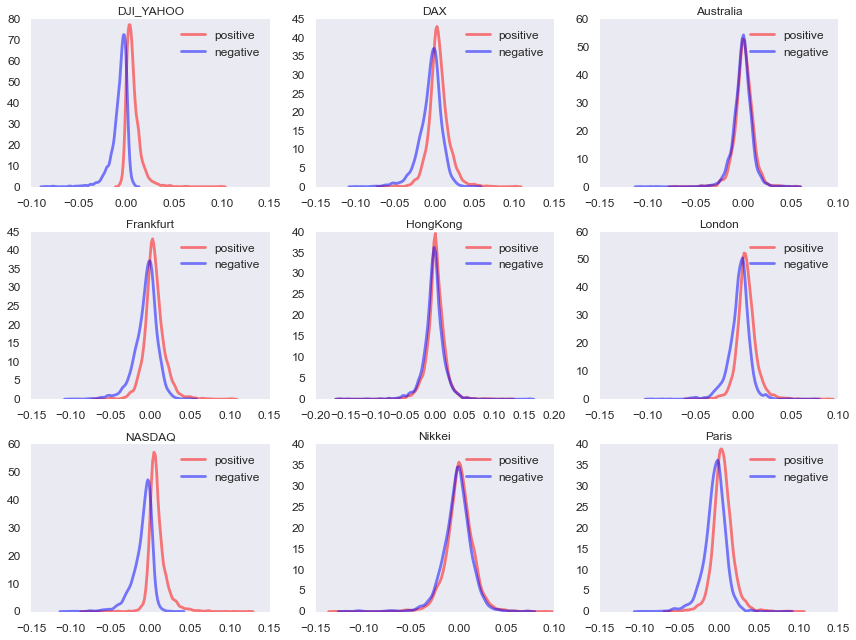

In [28]:
fig,axes=plt.subplots(nrows=3, ncols=3,figsize=(12, 9),tight_layout=True)
change_df['ud']=change_df['SP_Adj_Close']>=0
positive=change_df[change_df.ud==1]
negative=change_df[change_df.ud==0]
for ax, col in zip(axes.ravel(), features):
    sns.kdeplot(positive[col],ax=ax,color='r',label='positive',alpha=0.5)
    sns.kdeplot(negative[col],ax=ax,c='b',label='negative',alpha=0.5)
    ax.grid(False)
    ax.legend(loc='upper right',fontsize=12)
    ax.tick_params(labelsize=12)
    ax.set_title(col,size=12)

As seen from this chart, the most separable features are DJI and NASDAQ, with distinct conditioned distribution of return. This of course makes sense as they both represent the US stock market overall and a number of stocks are overlapping with that in the basket of S&P 500. However, DJI and NASDAQ would not serve to be good indicators because they appear the same time as S&P 500. More useful information is global indices, which are determined before the close (or even open) of NYSE and NASDAQ - we can act on such information. An interesting observation is that S&P 500 is more closely related to European indices (DAX, Frankfurt, London and Paris) and they are fairly separable, while for Asian and Australian market, the two distributions are barely separable.

###2.1 Time series plots of index and features

In [9]:
big_df['Date'] =  pd.to_datetime(big_df['Date'])

####2.1.1 US Indices trend

We first explore the times series trend of S&P 500 vs. other US indices.

In [29]:
indices_us = big_df[['Date', 'SP_Adj_Close', 'DJI_YAHOO', 'NASDAQ']].set_index('Date')

In [30]:
# Normalize to initial price
indices_us['SP_Adj_Close'] = indices_us['SP_Adj_Close']/indices_us['SP_Adj_Close'].values[0]
indices_us['DJI_YAHOO'] = indices_us['DJI_YAHOO']/indices_us['DJI_YAHOO'].values[0]
indices_us['NASDAQ'] = indices_us['NASDAQ']/indices_us['NASDAQ'].values[0]
indices_us.columns = ['S&P 500', 'Dow Jones', 'NASDAQ']

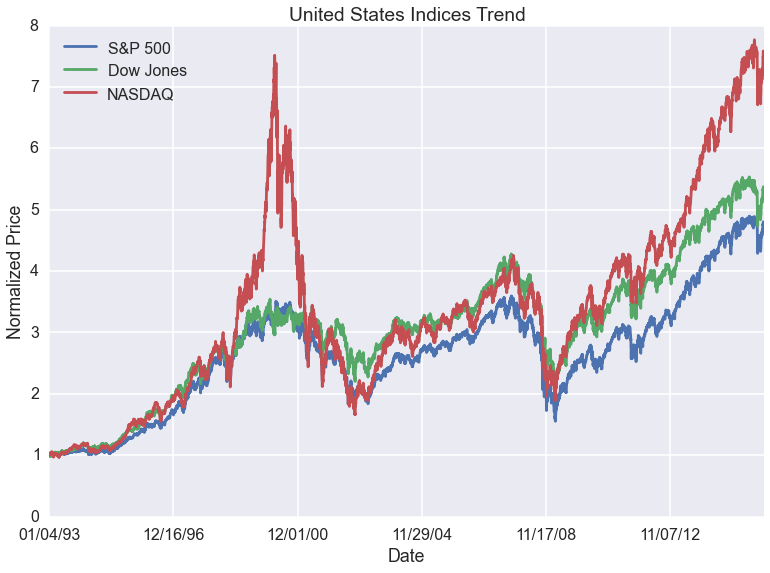

In [31]:
indices_us.plot()
plt.title('United States Indices Trend')
plt.ylabel('Normalized Price')
plt.show()

This figure clearly shows the trends of the indices are highly correlated.

Dow Jones (DJI) contains 30 large companies and is also contained in S&P 500, weighted differently. The trend of Dow Jones is largely overlapping with S&P 500 but eventually outperforms by a margin. The reason for that is that the constant rebalancing of Dow Jones removes the companies that are no longer considered as "big and representative", and every rebalancing has a bigger effect given that it counts 1/30 of the composite. Such companies with good earning statistics will outperform in the long run.

Noticably, between 1999 and 2001, NASDAQ rocketed up but later dropped down almost instantly by more than a half. This is the famous "Dot com bubble" when people got over-excited about high tech companies and resulted in highly overvalued stocks, which is not sustainable. Recently since 2013, NASDAQ soared up again against DJI and S&P, indicating the good investment values in the growing small sized tech companies.

####2.1.2 Global Indices trend

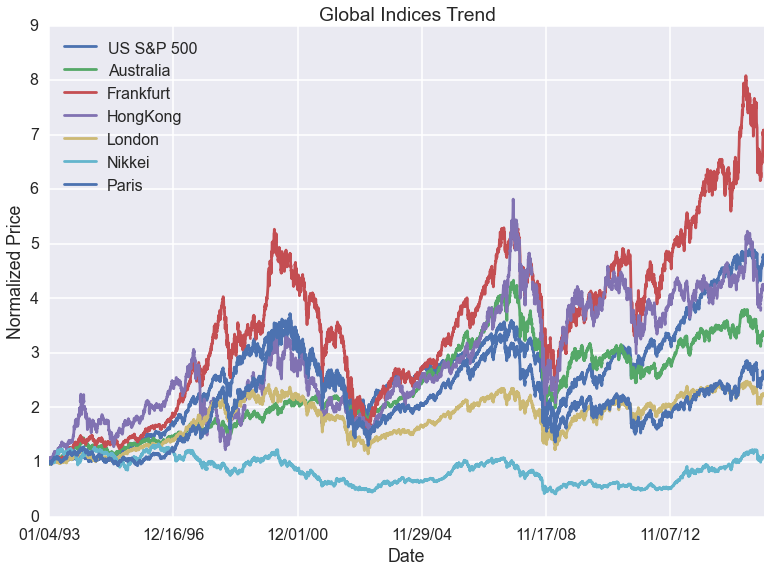

In [32]:
indices_inter = big_df[['Date', 'SP_Adj_Close', 'Australia','Frankfurt', 'HongKong','London', u'Nikkei', u'Paris']].set_index('Date')
# Normalize to initial price
indices_inter['SP_Adj_Close'] = indices_inter['SP_Adj_Close']/indices_inter['SP_Adj_Close'].values[0]
indices_inter['Australia'] = indices_inter['Australia']/indices_inter['Australia'].values[0]
indices_inter['Frankfurt'] = indices_inter['Frankfurt']/indices_inter['Frankfurt'].values[0]
indices_inter['HongKong'] = indices_inter['HongKong']/indices_inter['HongKong'].values[0]
indices_inter['London'] = indices_inter['London']/indices_inter['London'].values[0]
indices_inter['Nikkei'] = indices_inter['Nikkei']/indices_inter['Nikkei'].values[0]
indices_inter['Paris'] = indices_inter['Paris']/indices_inter['Paris'].values[0]
indices_inter.rename(columns={'SP_Adj_Close':'US S&P 500'}, inplace=True)

indices_inter.dropna()
indices_inter.plot()
plt.title('Global Indices Trend')
plt.ylabel('Normalized Price')
plt.show()

This figure shows that mostly the global indices are correlated, although not as significant as DJI and NASDAQ. The global macroecomomic trends drives the indices. In drastic events like the financial crisis (2008-2009), dot-com bubble influence the global market in all.

####2.1.3 Log return time series

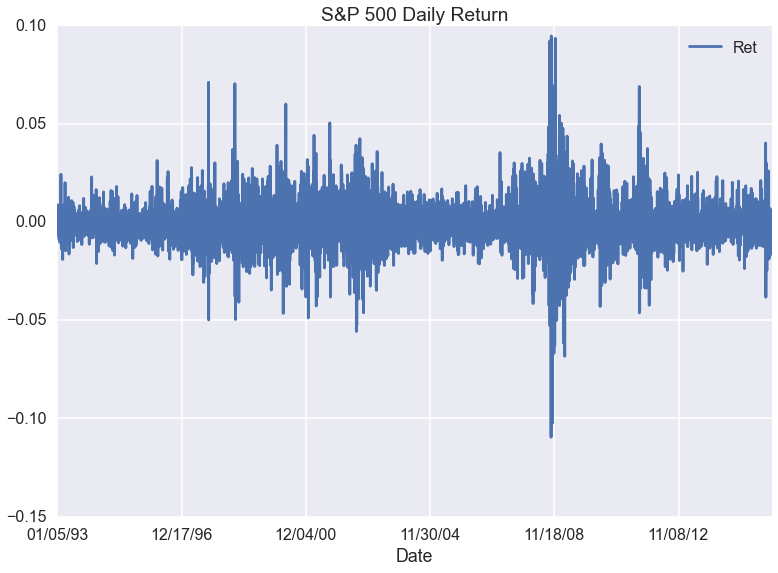

In [20]:
sp_ret = np.log(big_df[[u'SP_Adj_Close']]).shift(1)-np.log(big_df[[u'SP_Adj_Close']])
sp_ret_df = pd.DataFrame({'Date': big_df['Date'],
                        'Ret':sp_ret[u'SP_Adj_Close'].values})
sp_ret_df = sp_ret_df.dropna()
sp_ret_df = sp_ret_df.set_index('Date')
sp_ret_df.plot()
plt.title('S&P 500 Daily Return')
plt.show()

Time series plot of the S&P 500 daily return shows constant mean (by symmetry) but not covariance stationary. Large variances happen at time stamps of severe market events (usually bad) - 2008 to 2009 financial crisis, for example. Such property makes it a little hard to apply time series models that generally requires covariance stationarity. We then explore using GARCH to fit this return sequence in section 4.

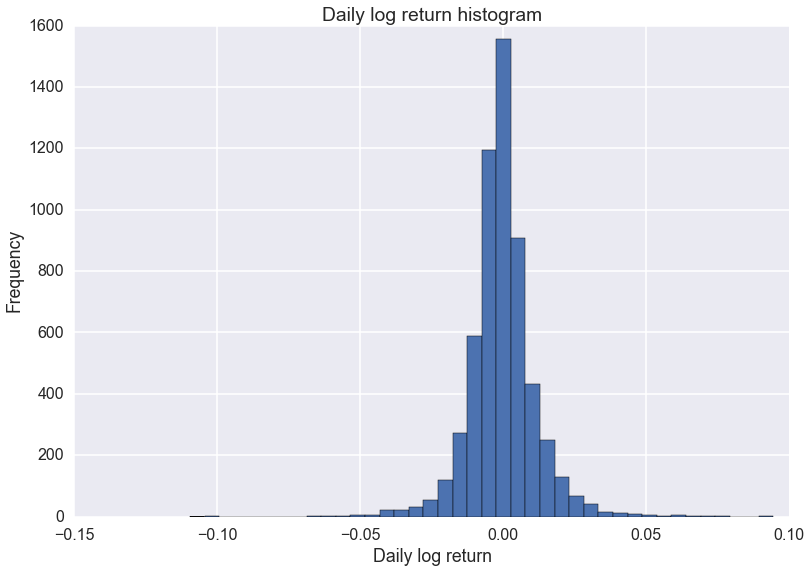

In [34]:
plt.hist(sp_ret_df.Ret, bins=40)
plt.title('Daily log return histogram')
plt.ylabel('Frequency')
plt.xlabel('Daily log return')
plt.show()

To test the normality of the return sequence, we plot the histogram of all returns. Even though it looks fairly normal, we should pay attention to the extrema at both tails.

###2.2 Auto-correlation, cross-correlation

Autocorrelation function for S&P 500:

In [35]:
from pandas.tools.plotting import autocorrelation_plot

In [36]:
def plot_autocorrelation(x, label = ''):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    result = r/(variance*(np.arange(n, 0, -1)))
    plt.plot(range(0, len(result[:100])), result[:100])
    plt.title('Autocorrelation of '+label)
    plt.show()
    return result

def plot_crosscorrelation(x,y, labelx = '', labely = ''):
    nx = len(x)
    variancex = x.var()
    x = x-x.mean()
    ny = len(y)
    variancey = y.var()
    y = y-y.mean()
    
    r = np.correlate(x, y, mode = 'full')[-nx:]
    result = r/(np.sqrt(variancex*variancey)*(np.arange(nx, 0, -1)))
    plt.plot(range(1, 100), result[1:100])
    plt.title('S&P 500 Daily Return')
    plt.ylim = ((-0.1,0.1))
    plt.title('Crosscorrelation of '+labelx+' and '+labely)
    plt.ylabel('Crosscorrelation')
    plt.xlabel('Lag')
    plt.show()
    return result
    

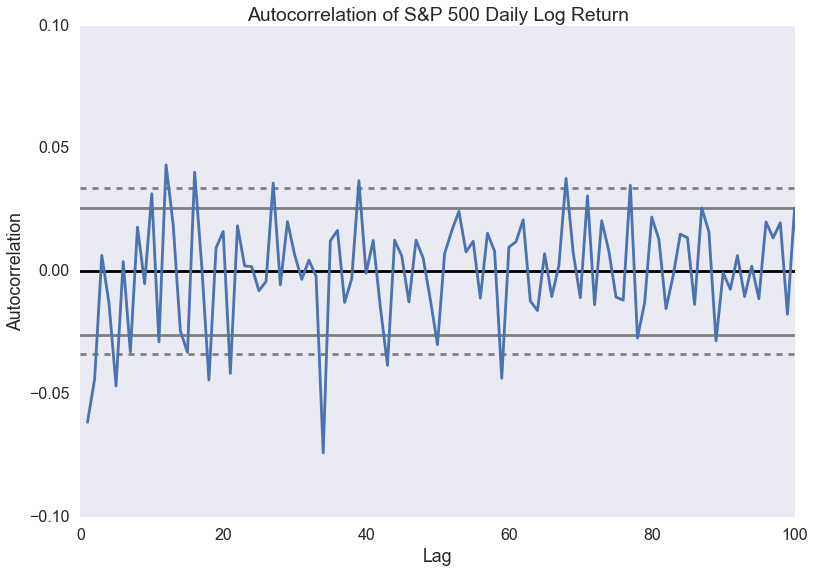

In [37]:
corr_ax1 = autocorrelation_plot(sp_ret_df)
corr_ax1.set_xlim(0,100)
corr_ax1.set_ylim(-0.1,0.1)
plt.title('Autocorrelation of S&P 500 Daily Log Return')
plt.show()

This autocorrelation is very random with no clear pattern of previous memory. This suggests the future returns are hardly correlated with the return standing today, i.e. no momentum.

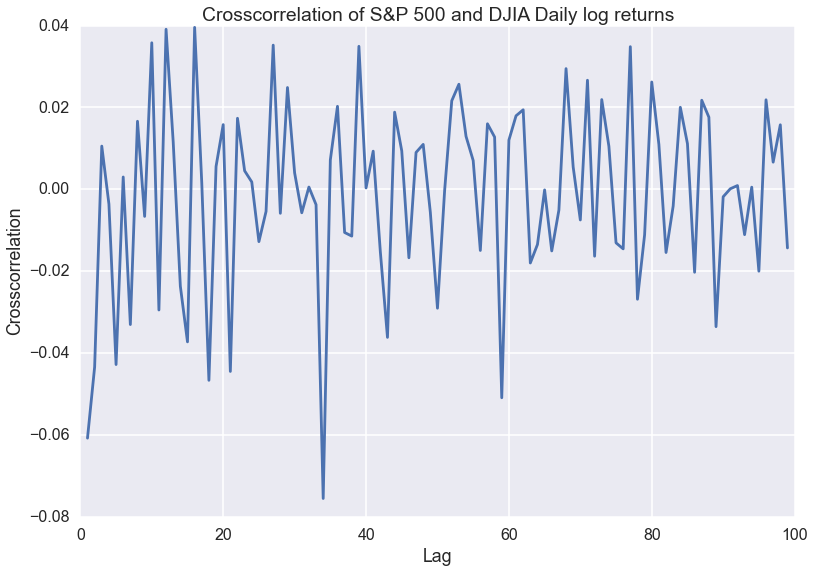

array([ 0.96257408, -0.06082401, -0.04343281, ...,  0.13007772,
        0.02370528,  0.02692409])

In [38]:
dji_ret = np.log(big_df[[u'DJI_YAHOO']]).shift(1)-np.log(big_df[[u'DJI_YAHOO']])
dji_ret_df = pd.DataFrame({'Date': big_df['Date'],
                        'Ret_dji':dji_ret[u'DJI_YAHOO'].values})
dji_sp_ret_df = pd.merge(sp_ret_df.reset_index(), dji_ret_df, on='Date', how='left')
dji_sp_ret_df = dji_sp_ret_df.set_index('Date')
dji_sp_ret_df = dji_sp_ret_df.dropna()
plot_crosscorrelation(dji_sp_ret_df['Ret'].values, dji_sp_ret_df['Ret_dji'], 'S&P 500', 'DJIA Daily log returns')


The cross correlation of S&P 500 vs DJI daily returns shows again very random fluctuations. This indicates we cannot act on DJI last information to predict S&P 500 future returns.

.We further explore the correlation within selected features

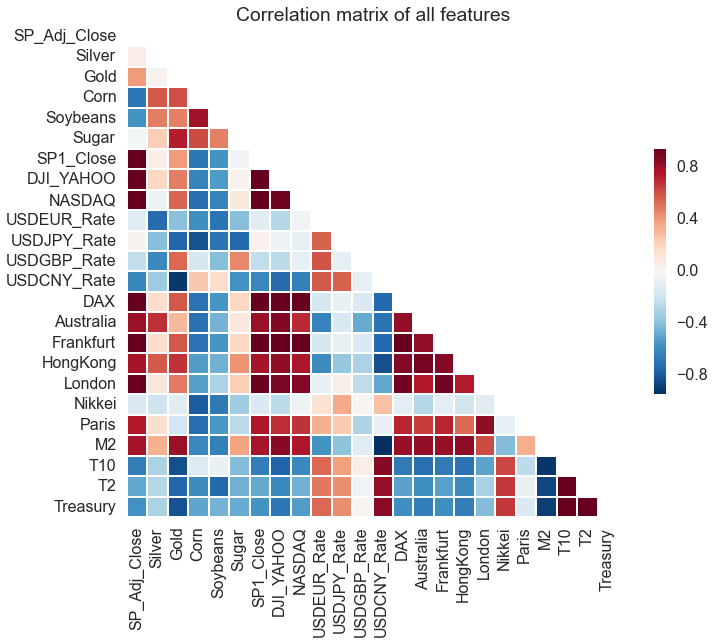

In [52]:
corr_df = big_df[[u'SP_Adj_Close', 
                  u'Silver', u'Gold', u'Corn', u'Soybeans', u'Sugar', 
                  u'SP1_Close', u'DJI_YAHOO', u'NASDAQ',
                  u'USDEUR_Rate', u'USDJPY_Rate', u'USDGBP_Rate',u'USDCNY_Rate',
                  u'DAX',u'Australia', u'Frankfurt', u'HongKong',
                  u'London', u'Nikkei', u'Paris',
                  u'M2', u'T10', u'T2', u'Treasury']]
indices_inter = indices_inter.dropna()
corr = corr_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix of all features')
plt.show()

This big correlation matrix shows really interesting patterns:

1. For S&P 500, US and global indices, and money supply are highly and positively correlated with it. Commidities such as corn and soybeans, treasury bonds are negatively correlated, as they are alternative investments corresponding to stock markets.
2. The indices are internally highly correlated, suggesting market globalization.
3. Commodities themsevles are affected by the currency exchange rates.
4. Nikkei has been bearish for the past two decades and thus not correlated with the bullish global market as a whole.

##3. Baseline

In the base line case, we simply use a coin flip. If the fair coin turns out to be head, we predict the market should go up and vice versa.

We further use S&P 500 futures (basis) to predict: if for this day futures is lower than its underlying S&P 500, we predict the next day S&P 500 will go down.

In [5]:
df = big_df.copy()
df['Date'] = pd.to_datetime(df['Date'])

df = df.sort('Date').set_index('Date')

# Observe 2015 onwards
predict=datetime.datetime(2015,1,1)
df_b = df[df.index>=predict]

# Column determining next close is either up or down
df_b['ud']=df_b['SP_Adj_Close']>=df_b['SP_Adj_Close'].shift(1)

# if future >= index, predict up
df_b['future_ud']=df_b['SP1_Close'].shift(1)>=df_b['SP_Adj_Close'].shift(1)

# Compare with random coin flip
df_b['random_ud']=np.random.uniform(0,1,df_b.shape[0])>0.5

df_b=df_b[1:]

baseline=df_b[['future_ud','random_ud','ud']]

baseline['random']=baseline.random_ud==baseline.ud
baseline['future']=baseline['future_ud']==baseline['ud']
print baseline.random.mean(),baseline.future.mean()

0.516746411483 0.555023923445


A coin flip sequence gives us a prediction accuracy of 52%, as we expected, fairly close to 50%. Using futures to predict is better: 55%.

##4. Time series analysis

###4.1 ARIMA model

We first fit the S&P 500 time series using ARIMA model. To find the best model parameters, we loop over lag 1-5 for the regressor as well as moving average. We use AIC as benchmark to determine which parameter sets can minimize it. To note, ARIMA model assumes covariance stationarity, which we address it in the next part, GARCH.

In [11]:
import statsmodels.api as sm

In [21]:
sp_ret_df.index = pd.to_datetime(sp_ret_df.index)

In [36]:
fin_aic= np.inf
for p in range(1,5,1):
    for d in range(2):
        for q in range(1,5,1):
            try:
                arima_model=sm.tsa.ARIMA(sp_ret_df['Ret'].iloc[1:],order=(p,d,q)).fit()
                cur_aic=arima_model.aic
                if cur_aic < fin_aic:
                    fin_aic = cur_aic
                    fin_order = (p, d, q)
            except:
                pass

We look at the autocorrelation of the residual fitted by ARIMA model.

(-0.1, 0.1)

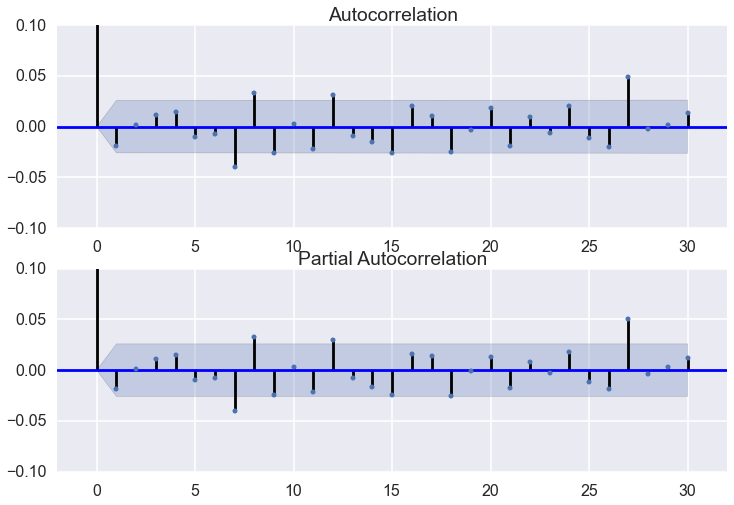

In [39]:
arima_final=sm.tsa.ARIMA(sp_ret_df['Ret'].iloc[1:],order=fin_order).fit()
resid=arima_final.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1.set_xlim([-2,32])
ax1.set_ylim([-0.1,0.1])
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=30, ax=ax2)
ax2.set_xlim([-2,32])
ax2.set_ylim([-0.1,0.1])

The fitted return time series is shown below in green.

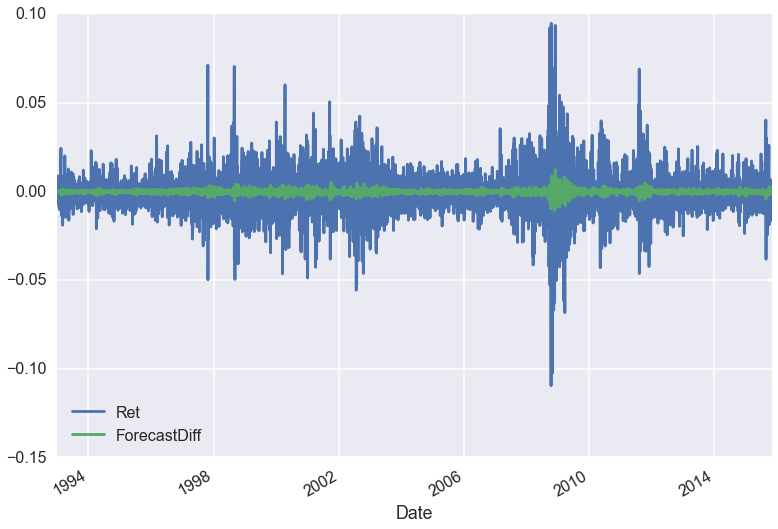

In [130]:
sp_ret_df['ForecastDiff'] = arima_final.fittedvalues  
sp_ret_df[['Ret', 'ForecastDiff']].plot() 

We characterize the performance by ARIMA model, and this

In [131]:
np.mean((sp_ret_df['Ret'].values>=0)==(sp_ret_df['ForecastDiff'].values>=0))

0.52382608695652177

We predict future returns using this arima model for the next 252 days.

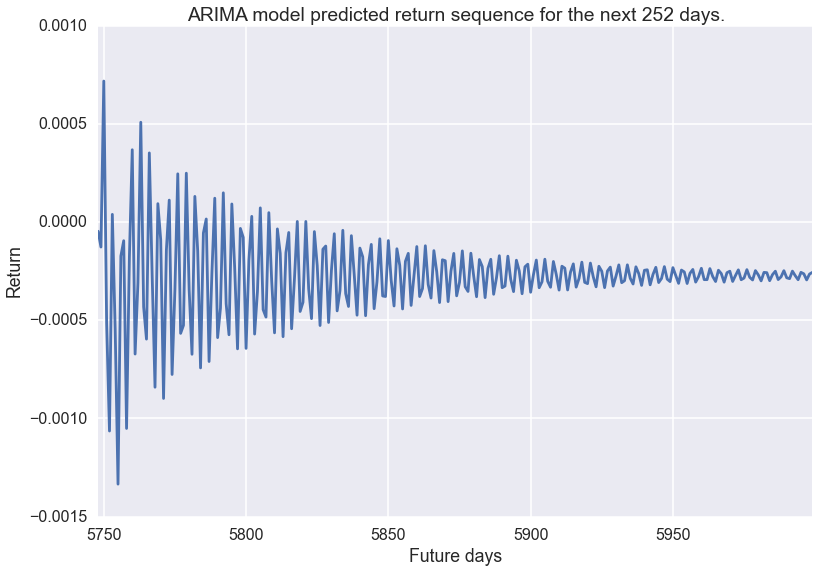

In [54]:
arima_final.predict(start=0, end=6000)[5748:6000].plot()
plt.title('ARIMA model predicted return sequence for the next 252 days.')
plt.ylabel('Return')
plt.xlabel('Future days')
plt.show()

The return curve is expected to converge to the mean return and oscillating as a result of moving average.


###4.2 GARCH model

Here we call R code to predict the return series using GARCH model. Since R already provides a good package for GARCH modleing, we did it then in R and copied the code here. The plots shows the the fitted variance from 1993 to 2015. And the model is able to capture the high values of volatility during severe market events.

<code>
library(data.table)
library(rugarch); # GARCH software
sp = fread('sp_adj_r.csv')
mY = matrix(log(sp,ncol=1))
mYdiff = diff(mY,1)
par(mfcol=c(1,1), mar=c(2,2,1.0,0.0), oma=c(1.5,2,1,1))
spec = ugarchspec() # use GARCH software to estimate model
fit = ugarchfit(data = mYdiff, spec = spec)
plot(fit,which="all")
</code>

(-0.5, 713.5, 222.5, -0.5)

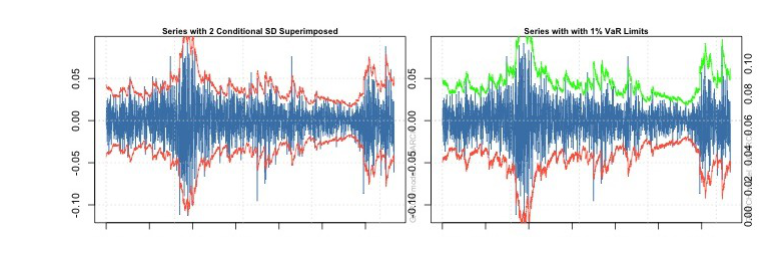

In [135]:
import scipy
garch_plot = scipy.misc.imread('./data/garch.jpg')
plt.imshow(garch_plot)
plt.axis('off')

Forecasting the time series for the next 100 days:

<code>spec = getspec(fit);
setfixed(spec) <- as.list(coef(fit));
forecast = ugarchforecast(spec, n.ahead = 100, n.roll = 1000, data = mYdiff[4000:5750, ,drop=FALSE], out.sample = 1000);
sigma(forecast);
fitted2 = fitted(forecast);
plot(fitted2)
</code>

(-0.5, 741.5, 630.5, -0.5)

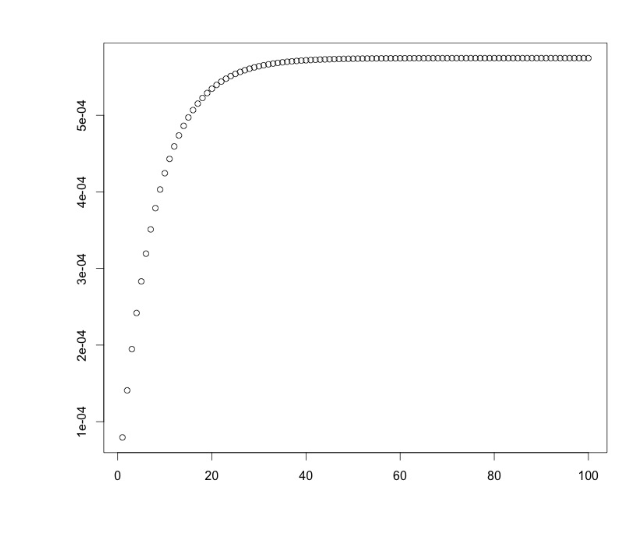

In [56]:
garch_fore = scipy.misc.imread('./data/garch_forecast.jpeg')
plt.imshow(garch_fore)
plt.axis('off')

Forecasting from 2015-10-30, the log return will gradually increase and plateaus at close to 0.058%.

###4.3 Kalman Filtering

We hypothesize S&P 500, reflects the general market trend (smooth) with economic characteristics underlying it, but is obstructed by noises abnormalities. Kalman filtering will be a good candidate to extract the true trend out of the observed data. We assume the index can be written as a local level model:
$$
y_t = \alpha_t + \epsilon_t\\
\alpha_t = \alpha_{t-1} + \eta_{t-1}
$$
where $\epsilon$ and $\eta$ are white noise.

Kalman filtering progresses through time and filteres the state out of the index time series.

In [57]:
from pykalman import KalmanFilter

In [58]:
sp_ts = big_df[['Date', 'SP_Adj_Close']]

In [59]:
# Initialize a local state model
kf = KalmanFilter(transition_matrices = [1], observation_matrices = [1])

# Take in the S&P 500 observations
measurements = sp_ts['SP_Adj_Close'].values
kf = kf.em(measurements, n_iter=1)
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

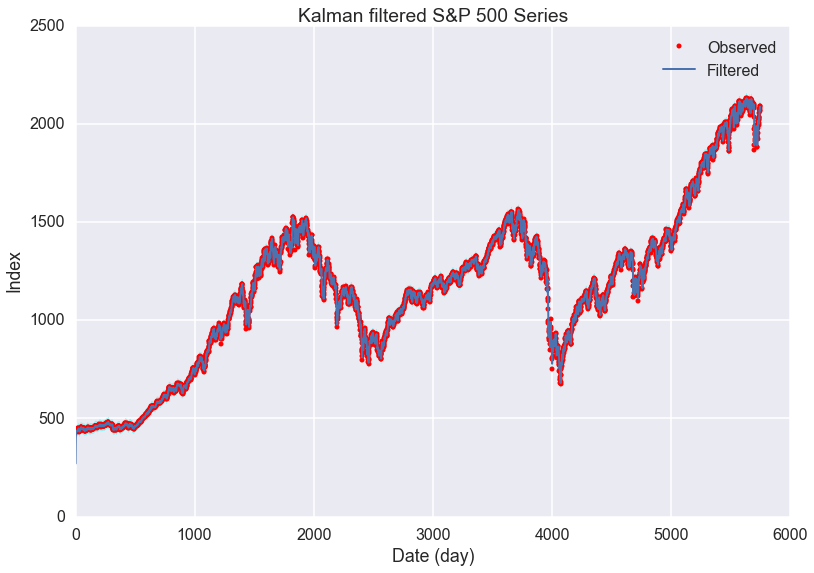

In [60]:
plt.plot((sp_ts['SP_Adj_Close'].values), 'ro', markersize=5, label='Observed')
plt.plot((filtered_state_means), linewidth = 2, label = 'Filtered')
plt.fill_between(range(len(filtered_state_means)), 
                 filtered_state_means.flatten()-filtered_state_covariances.flatten(), 
                 filtered_state_means.flatten()+filtered_state_covariances.flatten(), alpha=0.3, color='cyan')
plt.title('Kalman filtered S&P 500 Series')
plt.xlabel('Date (day)')
plt.ylabel('Index')
plt.legend()
plt.show()

The Kalman filtered result fits very good on the result. This is expected because Kalman filter stands on the current time stamp and predict the next change based on all the historical information available.

Plotting Kalman filtered time series at the tail of the S&P 500.

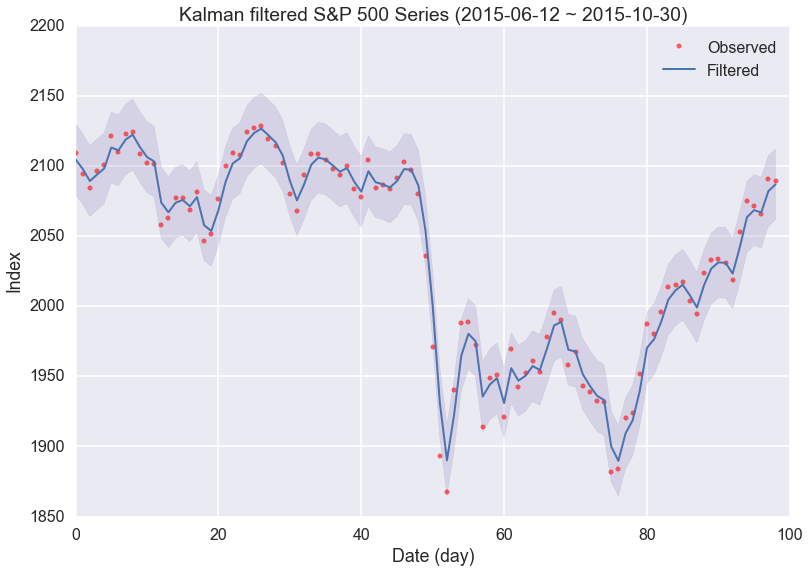

In [97]:
plt.plot((sp_ts['SP_Adj_Close'].values)[-100:-1], 'ro', alpha = 0.6, markersize=5, label='Observed')
plt.plot((filtered_state_means)[-100:-1], linewidth = 2, label='Filtered')
plt.fill_between(range(99), 
                 (filtered_state_means.flatten()-filtered_state_covariances.flatten())[-100:-1], 
                 (filtered_state_means.flatten()+filtered_state_covariances.flatten())[-100:-1], 
                 alpha=0.2, color=sns.color_palette()[3], label='Spread')
plt.title('Kalman filtered S&P 500 Series (2015-06-12 ~ 2015-10-30)')
plt.xlabel('Date (day)')
plt.ylabel('Index')
plt.legend()
plt.show()

Here we compare the daily trend of the Kalman filtered result vs. observed market trend, where a "True" is a up, and a "False" is a down.

In [78]:
# Calculate the daily trend of the observed market
# where True stands for 
obs_kf = sp_ts['SP_Adj_Close'].values
obs_kf = obs_kf[1:] > obs_kf[:-1]

# daily trend of the filtered result
fil_kf = filtered_state_means.flatten()[1:] > filtered_state_means.flatten()[:-1]

# Get the accuracy
kf_match = (obs_kf == fil_kf)
np.mean(kf_match)

0.86713043478260865

Through out the time series, the filtered result resembles very well with the true observed result.

##5. Machine Learning Analysis

We defined helper functions that organizes various classifiers.

In [61]:
import operator
import datetime

In [139]:
# define classifiers
from sklearn.svm import LinearSVC
def LinearSVM(X_train, y_train, X_test, y_test, parameters):
    clf=LinearSVC(loss="hinge",C=parameters[0])
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf, accuracy

from sklearn.ensemble import RandomForestClassifier
def RandomForest(X_train, y_train, X_test, y_test, parameters):
    clf = RandomForestClassifier(n_estimators=parameters[0],n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf, accuracy

from sklearn.linear_model import LogisticRegression
def LogRegress(X_train, y_train, X_test, y_test, parameters):
    clf = LogisticRegression(C=parameters[0])
    clf.fit(X_train,y_train)
    accuracy = clf.score(X_test,y_test)
    return clf, accuracy

from sklearn import neighbors
def KNN(X_train, y_train, X_test, y_test, parameters):
    clf = neighbors.KNeighborsClassifier(n_neighbors=parameters[0])
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf,accuracy

from sklearn.naive_bayes import GaussianNB
def GNB(X_train, y_train, X_test, y_test):
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf,accuracy

from sklearn.ensemble import AdaBoostClassifier
def AdaBoost(X_train, y_train, X_test, y_test, parameters):
    n = parameters[0]
    l =  parameters[1]
    clf = AdaBoostClassifier(n_estimators = n, learning_rate = l)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf, accuracy

The following functions:

mask separates the training data and test data

Cross-validation as describe in http://francescopochetti.com/part-iv-modelfeature-selection/

1. Split data in train and test set given a Date (in my case after 1 April 2014 included).
2. Split train set (before 1 April 2014 not included) in 10 consecutive time folds.
3. Then, in order not lo lose the time information, perform the following steps:
4. Train on fold 1 –>  Test on fold 2
5. Train on fold 1+2 –>  Test on fold 3
6. Train on fold 1+2+3 –>  Test on fold 4
7. Train on fold 1+2+3+4 –>  Test on fold 5
8. Train on fold 1+2+3+4+5 –>  Test on fold 6
9. Train on fold 1+2+3+4+5+6 –>  Test on fold 7
10. Train on fold 1+2+3+4+5+6+7 –>  Test on fold 8
11. Train on fold 1+2+3+4+5+6+7+8 –>  Test on fold 9
12. Train on fold 1+2+3+4+5+6+7+8+9 –>  Test on fold 10
13. Compute the average of the accuracies of the 9 test folds (number of folds  – 1)

SearchGrid returns the best fit parameters

cv_optimize gets the best classifier.

In [140]:
def mask(df, features,y,start_test):
    '''
    To separate dataset and get X_train, X_test, y_train, y_test
    '''
    dataset=df[features+[y]].dropna()
    X=dataset[features]
    y=dataset[y]
    X_train = X[X.index < start_test]
    y_train = y[y.index < start_test]    
    X_test = X[X.index >= start_test]    
    y_test = y[y.index >= start_test]
    return X_train, y_train, X_test, y_test 

def classifier(X_train, y_train, X_test, y_test, method, parameters):
    '''
    To call different classifiers
    '''
    if method == 'RF':   
        return RandomForest(X_train, y_train, X_test, y_test, parameters)
    elif method == 'SVM':   
        return LinearSVM(X_train, y_train, X_test, y_test, parameters)
    elif method == 'LOG':
        return LogRegress(X_train, y_train, X_test, y_test, parameters)
    elif method == 'KNN':
        return KNN(X_train, y_train, X_test, y_test, parameters)
    elif method == 'GNB':
        return GNB(X_train, y_train, X_test, y_test)
    elif method == 'ADA':
        return AdaBoost(X_train, y_train, X_test, y_test, parameters)

# In time series, we must validate the dataset according to time rather than randomly separating dataset
# CV and SearchGrid are referenced from 
# http://francescopochetti.com/stock-market-prediction-part-ii-feature-generation/
def CV(X_train, y_train, folds, method, parameter):
    '''
    To get the average score of cross validation
    
    '''
    k = int(np.floor(float(X_train.shape[0])/folds))
    acc = np.zeros(folds-1)
    for i in range(2, folds+1):
        split = float(i-1)/i
        data = X_train[:(k*i)]
        output = y_train[:(k*i)]
        index = int(np.floor(data.shape[0]*split))
        X_tr = data[:index]        
        y_tr = output[:index]
        X_te = data[(index+1):]
        y_te = output[(index+1):]        
        acc[i-2] = classifier(X_tr, y_tr, X_te, y_te, method, parameter)[1]
    return acc.mean()  

def SearchGrid(X_train, y_train, folds, method, grid):
    '''
    To get the best parameters for a given classifier
    '''
    param = grid.keys()
    finalGrid = {}
    if len(param) == 1:
        for value_0 in grid[param[0]]:
            parameters = [value_0]
            accuracy = CV(X_train, y_train, folds, method, parameters)
            finalGrid[accuracy] = parameters
        final = sorted(finalGrid.iteritems(), key=operator.itemgetter(0), reverse=True)          
        return final[0]
    elif len(param) == 2:
        for value_0 in grid[param[0]]:
            for value_1 in grid[param[1]]:
                parameters = [value_0, value_1]
                accuracy = CV(X_train, y_train, folds,method, parameters)
                finalGrid[accuracy] = parameters
        final = sorted(finalGrid.iteritems(), key=operator.itemgetter(0), reverse=True)
        return final[0]
    
def cv_optimize(X_train, y_train, X_test, y_test, folds, method, grid):
    '''
    Return to a best classifier
    '''
    if grid==[]:
        best=classifier(X_train, y_train, X_test, y_test, method, grid)
    else:
        param=SearchGrid(X_train, y_train, folds, method, grid)[1]
        best=classifier(X_train, y_train, X_test, y_test, method, param)
    return best[0]

In [141]:
#plot ROC curve
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(boxstyle='round,pad=0.3', alpha=0.2,)
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

###5.1 Prediction upon only knowledge of S&P 500 historical data

In [142]:
sp = pd.read_csv("big_df.csv")
sp_temp = sp.copy()
sp_temp.Date = pd.to_datetime(sp_temp.Date)
sp = sp_temp.sort('Date').set_index('Date')

sp['ud']=sp['SP_Adj_Close'].shift(-1)>=sp['SP_Adj_Close']

infor=['SP_Open','SP_High','SP_Low','SP_Volume','SP_Adj_Close']
infor1=['SP_Open_lag','SP_High_lag','SP_Low_lag','SP_Volume_lag','SP_Adj_Close_lag']

#use two-day information
for i in range(5):
    sp[infor1[i]]=sp[infor[i]].shift(1)

X_train, y_train, X_test, y_test=mask(sp,infor+infor1,'ud', predict)

In [143]:
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])

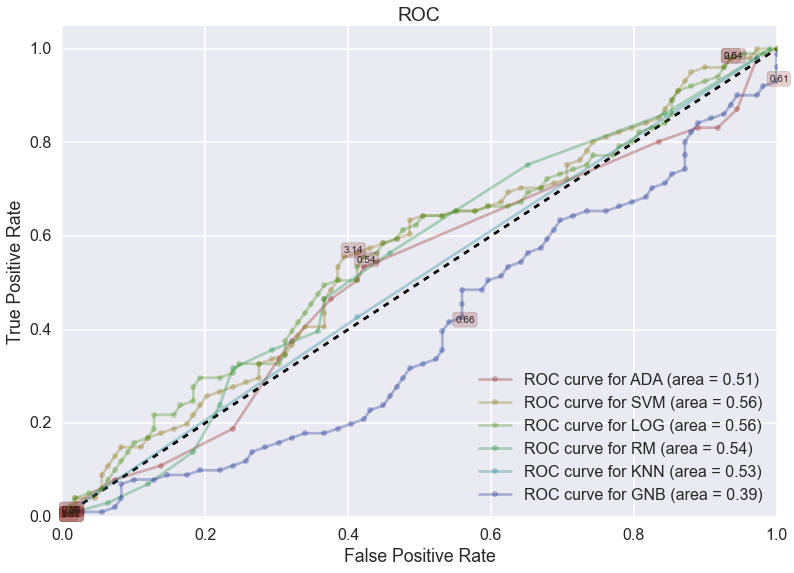

In [144]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

Using only historical S&P data, the ROC curve is marginally better, if not worse than coin flip case. This is expected as we simply cannot predict the next day trend by looking at today's trend.

###5.2 Prediction upon knowing historical futures data

In [145]:
future=['SP1_Open', 'SP1_High', 'SP1_Low', 'SP1_Close', 'SP1_Settle', 'SP1_Volume', 'SP1_Open_Interest']
future1=['SP1_Open_lag', 'SP1_High_lag', 'SP1_Low_lag', 'SP1_Close_lag', 'SP1_Settle_lag', 'SP1_Volume_lag', 'SP1_Open_Interest_lag']

# We used data lagging two days
for i in range(7):
    sp[future1[i]]=sp[future[i]].shift(1)

X_train, y_train, X_test, y_test=mask(sp,future+future1,'ud', predict)

In [146]:
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])

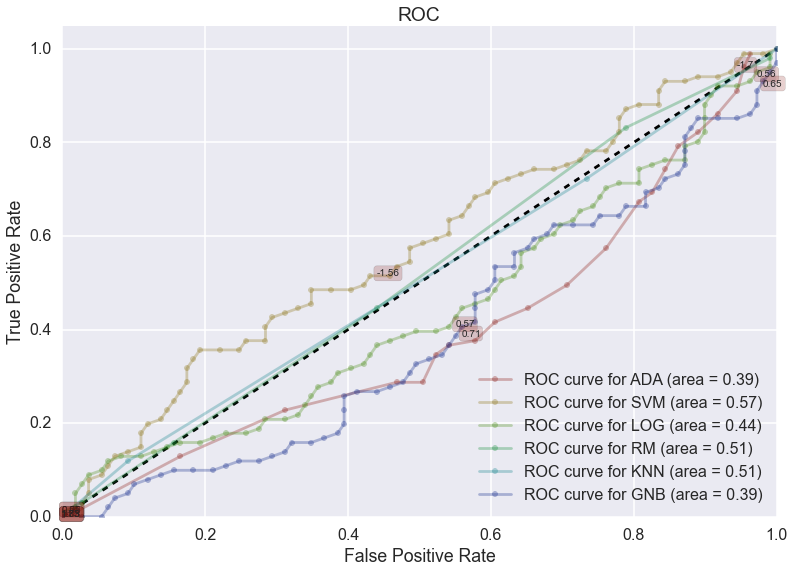

In [147]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

We test here our second assumption: today's futures price reflects expectation of the future stock price. If futures price is lower, we expect the stock to have a downward trend. The result turns out to be against this assumption: the prediction power is even worse than simply using the historical S&P 500 itself, with SVM yielding 57%, and ADA, LOG and GNB yielding predictions worse than coin flip.

###5.3 Prediction upon knowledge of global indices and currency exchange rates

In [148]:
df = pd.read_csv("change_df.csv")
df_temp = df.copy()
df_temp.Date = pd.to_datetime(df_temp.Date)
df = df_temp.sort('Date').set_index('Date')
# use data after 2015-1-1 as test data
predict=datetime.datetime(2015,1,1)

In [149]:
df1=df.copy()
df1['ud']=df1['SP_Adj_Close']>=0

In [150]:
features=['USDEUR_Rate', 'USDJPY_Rate','USDGBP_Rate', 'USDCNY_Rate', 'DAX', 'Australia','Frankfurt', 'HongKong', 'London','Nikkei', 'Paris']

In [151]:
X_train, y_train, X_test, y_test=mask(df1,features,'ud', predict)

In [152]:
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])

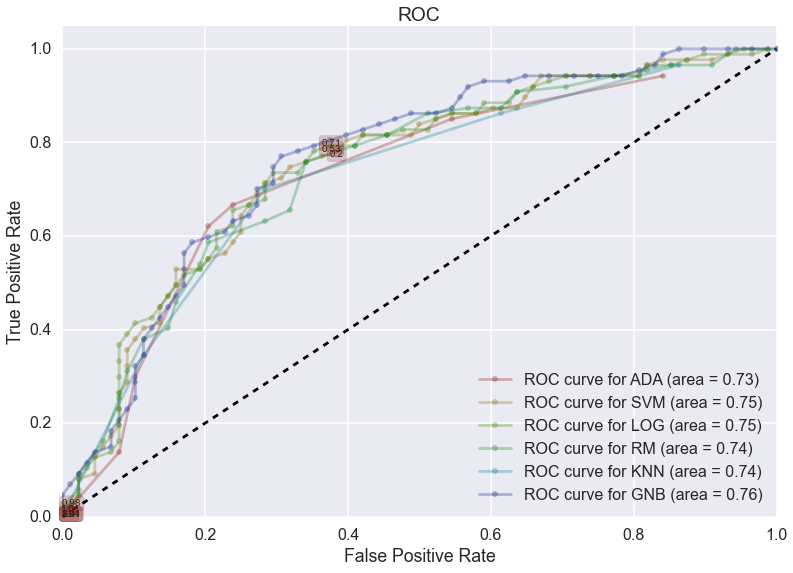

In [153]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

Here we used global indices and currency exchange rates to predict the next day's S&P close price. This time all of our classifiers range from 73% to 76%, suggesting good prediction power.

###5.4 Prediction upon knowledge of highly correlated historical indices

In [154]:
features=['Frankfurt', 'HongKong', 'London', 'Paris']
X_train, y_train, X_test, y_test=mask(df1,features,'ud', predict)

In [155]:
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])

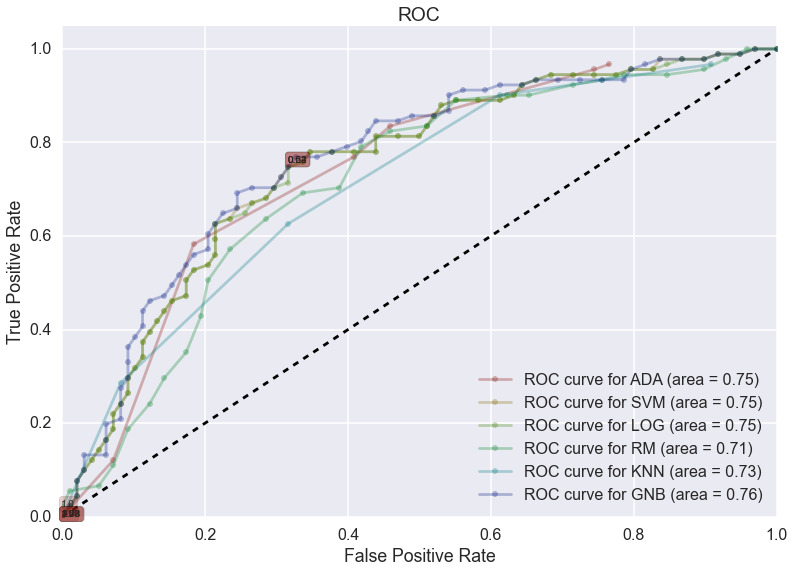

In [156]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

As discussed in section 2, the global indices are highly correlated with S&P 500. Here we exclude the currency exchange rates and use only the four preceding European and Hong Kong market historical data as features. The result turns out really good with prediction power ranging from 71% to 76%.

##6. Trend fitting using macroeconomic factors

We use multiple linear regression to fit the data.
$$
y_t = \beta_0 + \beta_1 X_{GDP} + \beta_2 X_{CPI} + \beta_3 X_{M2} + ...
$$

The underlying assumption is that these macroeconomic factors have linear relationships with the S&P 500 index.

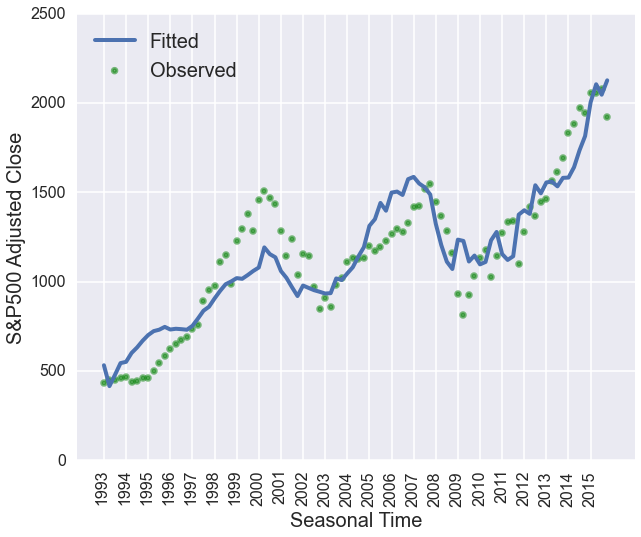

In [116]:
from sklearn.linear_model import LinearRegression

years = []
for i in range(1993,2016):
    years.append(str(i))
plt.figure(figsize=(10,8))
plt.xlabel('Seasonal Time',fontsize=20)
plt.ylabel('S&P500 Adjusted Close',fontsize=20)
#Plot our prediction
plt.plot(epreds,label='Fitted',linewidth=4.0)
plt.xticks(range(0,len(epreds),4),years,rotation='vertical')
#Plot the real data points
plt.scatter(range(len(fund['SP_Adj_Close'])),fund['SP_Adj_Close'],color='g',label='Observed',alpha=0.5,linewidth=3.0)
plt.legend(loc='upper left',fontsize=20)
plt.savefig('fa.png')
plt.show()

The model fits well with the general market trend. However, in severe market-specific events, the linear fitting will lose its power.

##7. Conclusions

In this project, we are motivated to predict the trend of S&P 500 index, one of the most quoted US stock market index in the world. Our starting point is that the market is affected by a number of features: 

1. the global market trend (global indices, commodity prices)
2. currency strength (exchange rates)
3. macroeconomic fundamentals
4. fluctuations of its derivatives.

We obtained historical market data of various instruments (about 50) and economic data from Quandl, Yahoo Finance, Wikipedia, Federal Reserve. For part one, we did exploratory data analysis, plotted the index series and analyzed the cross correlation between features and selected ones that have the most potential in prediction. We then implemented time series models to fit the S&P 500 trend and forecast. ARIMA fitted the log return with a prediction power of 53%. GARCH model is used to characterize the variance of the time series. Kalman filtering constantly adjust the prediction time series by including the new information. The fitted data has a trend fitting power of over 80%. Next, we moved on to machine learning, where we separated the dataset into train and test. We used various machine learning tools including KNN, SVM, logistic regression and KNB, to learn on the training data set of multiple combinations of features. We find simply using historical data has prediction power marginally better than than coin flip, if not worse. Using futures price data has prediction power similar to historical data. Eventually we used global indices that are highly correlated with the S&P 500 and the prediction power raised up to 76%. Finally, we extended our analysis and fit the index with linear regression on macroeconomic factors.

We thank the lecturers and TFs of AC209 Data Science for their help, especially Sail Wu for all his help along the way.